In [ ]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram

provider = IBMQ.load_account()
provider.get_backend('ibmq_qasm_simulator')

import itertools

In [20]:
##############################################################################################################
# this is based on the brilliant winning solution, which scored 4,004:
# https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/submissions/writeup_Nagayoshi.ipynb
#
# the winning solution had a small bit of unnecessary code 
# the solution here removes that and scores 3,578
#
# more in depth explanation of the solution...
#
# address  0,1,2,3..............................: 0000 to 1111, entangled with possible solutions
# register 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15: associated with various permutations
# register 16,17,18,19,20,21....................: ancillary qubits
# register 22...................................: entangled with reg 0-15
# register 23...................................: entangled with reg 16-23
# register 16...................................: the eventual oracle
#
# question: register[16] seems to be the overall oracle signal; but is also used as an anciallary qubit(?)
#
##############################################################################################################
def diffusion(qc,addr,aux):
    qc.h(addr[:])
    qc.x(addr[:])
    qc.h(addr[3])
    qc.mct(addr[0:3], addr[3], aux[:], mode='basic')
    qc.h(addr[3])
    qc.x(addr[:])
    qc.h(addr[:])
    
def tag_i(qc,addr,i):
    for n in range(4):
        if not i & (1<<n):
            qc.x(addr[n])

def entangle_qram(qc,addr,reg,data,part):
    for i in range(16):
        tag_i(qc,addr,i)
        perm = [c for c in itertools.permutations([0,1,2,3], 4)]
        if part == 1: # entangle the first 16 permutations into first 16 qubits of reg
            for m in range(16):
                a,b,c,d = perm[m]
                if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                    qc.mct(addr[:],reg[m], reg[-4:-2], mode='basic')
        else: # entangle the last 8 permutations into first 8 qubits of reg
            for m in range(16,24):
                a,b,c,d = perm[m]
                if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                    qc.mct(addr[:],reg[m-16], reg[-4:-2], mode='basic')
        tag_i(qc,addr,i)

def entangle_parts(qc,reg):
    qc.x(reg[:16])
    qc.mct(reg[:8],reg[22],reg[16:22], mode='basic') # tie 0-7 with reg[22]
    qc.mct(reg[8:16],reg[23],reg[16:22], mode='basic') # tie 8-15 with reg[23]
    qc.x(reg[:16])

def oracle(qc,addr,reg,data):
    
    entangle_qram(qc,addr,reg,data,part=1)
    entangle_parts(qc,reg)
    entangle_qram(qc,addr,reg,data,part=2)
    qc.x(reg[:8])
    qc.x(reg[16])
    qc.h(reg[16])
    
    # main oracle...
    # assess reg 0-7, reg 22 and 23... oracle is reg 16... uses reg 8-15 as ancillary (?)
    qc.mct(reg[:8]+reg[-2:],reg[16], reg[8:16], mode='basic')
    
    qc.h(reg[16])
    qc.x(reg[16])
    qc.x(reg[:8])    
    entangle_qram(qc,addr,reg,data,part=1)    
    entangle_parts(qc,reg)
    entangle_qram(qc,addr,reg,data,part=2)

def week3_ans_func(problem_set):
    data = [[[int([str(i),str(j)] in k) for j in range(4)] for i in range(4)] for k in problem_set]
    
    addr = QuantumRegister(4)
    reg = QuantumRegister(24)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(addr, reg,cr)
    # address preparation
    qc.h(addr[:])

    for i in range(1):
        oracle(qc,addr,reg,data)
        diffusion(qc,addr,reg)

    qc.measure(addr,cr)
    # Change the endian 
    qc = qc.reverse_bits() 
    
    return qc


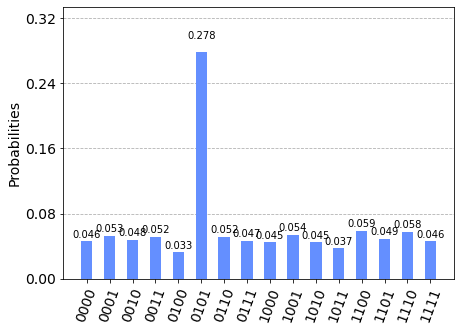

In [21]:
problem_set = \
    [[['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
    [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
    [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
    [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
    [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']],
    [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
    [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
    [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
    [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']]]

backend = provider.get_backend('ibmq_qasm_simulator')
shots = 1024
results = execute(week3_ans_func(problem_set), backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [22]:
# Submission code
from qc_grader import grade_ex3, prepare_ex3, submit_ex3

# Execute your circuit with following prepare_ex3() function.
# The prepare_ex3() function works like the execute() function with only QuantumCircuit as an argument.
job = prepare_ex3(week3_ans_func)

result = job.result()
counts = result.get_counts()
original_problem_set_counts = counts[0]
print('qc_cost',result.header.qc_cost)
original_problem_set_counts
# The bit string with the highest number of observations is treated as the solution.

Running week3_ans_func...
Computing cost...
Starting experiments. Please wait...
You may monitor the job (id: 5fea96edddf3cb001a259f25) status and proceed to grading when it successfully completes.
qc_cost 3578


{'0000': 47,
 '0001': 60,
 '0010': 44,
 '0011': 55,
 '0100': 47,
 '0101': 270,
 '0110': 49,
 '0111': 46,
 '1000': 45,
 '1001': 58,
 '1010': 44,
 '1011': 48,
 '1100': 44,
 '1101': 48,
 '1110': 47,
 '1111': 48}

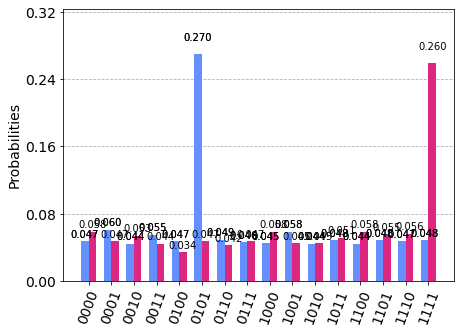

In [23]:
plot_histogram(result.get_counts())

In [24]:
grade_ex3(job)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 3578.
The lower your score the better!
Feel free to submit your answer.
